In [1]:
import jax
from jax import numpy as jnp, random as jr, value_and_grad

import optax

from env import Env
from svae.utils import split_into_batches
from network import init_mlp, identity, gumbel_softmax, onehot_sample, binary_cross_entropy

In [2]:
def forward(params, data, key, temperature=1.0, training=False):
    sample_key, key = jr.split(key)
    encoder_params, decoder_params = params

    logits = encoder(encoder_params, data)
    logits = logits.reshape(-1, N, K)

    if training:
        samples = gumbel_softmax(logits, sample_key, temperature)
    else:
        samples = onehot_sample(logits, sample_key)

    samples = samples.reshape(-1, N * K)
    decoded = decoder(decoder_params, samples)
    return decoded, jax.nn.softmax(logits, -2)


def test(params, data, key, env, num_plots=5):
    test_data = data[:num_plots, :]
    decoded, _ = forward(params, test_data, key)
    env.plot_sample(test_data.reshape(num_plots, 10, 10))
    env.plot_sample(decoded.reshape(num_plots, 10, 10))


def grad_fn(params, batch, key, temperature=1.0):
    decoded, probs = forward(params, batch, key, temperature, True)
    bce_loss = binary_cross_entropy(decoded, batch)
    kl_div = -jnp.sum(probs * jnp.log(probs + 1e-9))
    return bce_loss + kl_div

epoch 0: 5912.59375


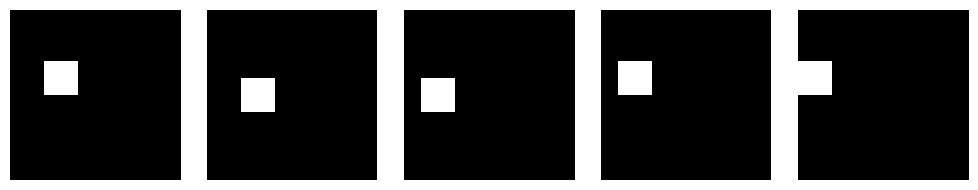

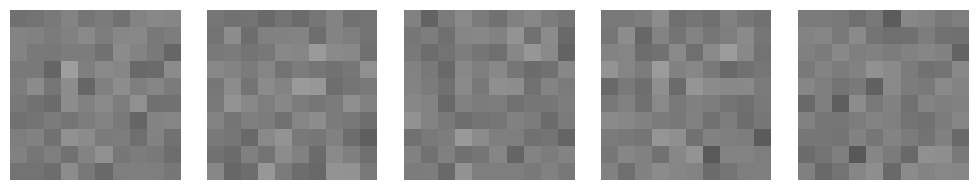

epoch 500: 257.1602783203125


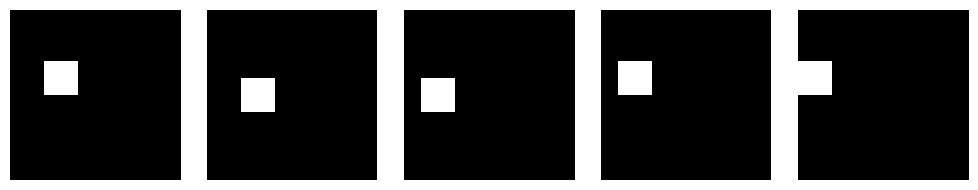

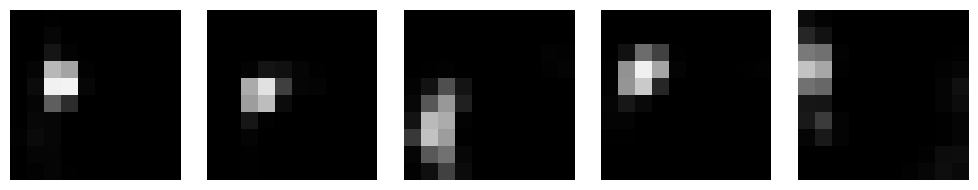

epoch 1000: 68.85015869140625


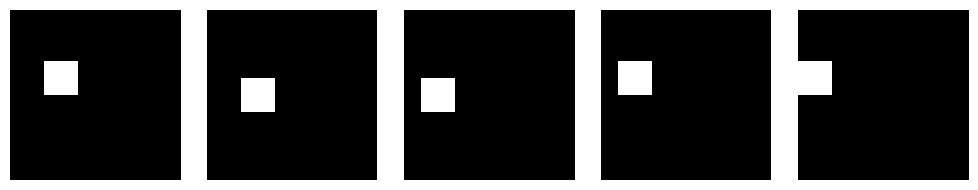

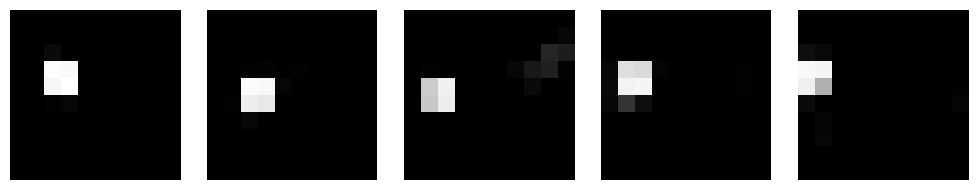

epoch 1500: 17.519746780395508


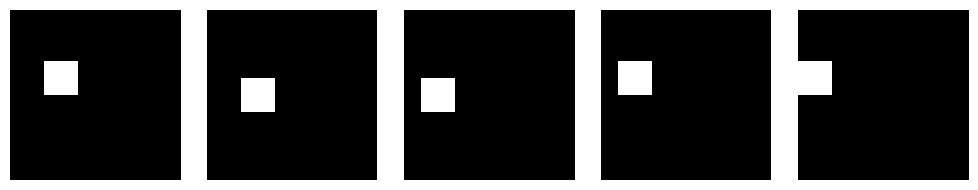

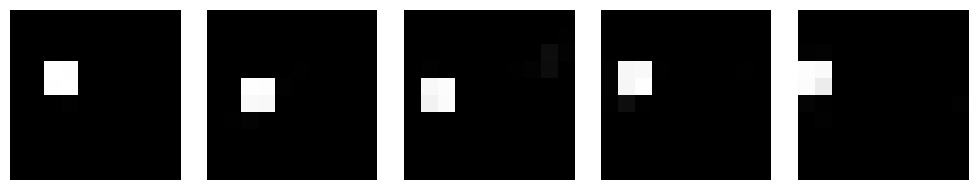

In [3]:
key = jr.PRNGKey(0)
num_epochs = 2000
T, B, N, K = 50, 64, 10, 10

env = Env()

data_key, key = jr.split(key)
data, _ = env.sample(data_key, B, 50)
S, T, D, D = data.shape
data = data.reshape(S * T, D * D)

batch_key, key = jr.split(key)
data_batches, num_batches = split_into_batches(batch_key, data, B)
get_batch = lambda i: data_batches[i % num_batches]

D = D * D
encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(400, jax.nn.relu), (N * K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, N * K, [(400, jax.nn.relu), (D, jax.nn.sigmoid)])
params = (encoder_params, decoder_params)

optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(params)


for epoch in range(num_epochs):
    nll, grads = value_and_grad(grad_fn, argnums=(0))(params, get_batch(epoch), key)
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if epoch % 500 == 0:
        print(f"epoch {epoch}: {nll}")
        test(params, data, key, env)